# Importing Libraries

In [40]:
import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
import haversine
import folium
import random
from IPython.display import IFrame
from sklearn.cluster import KMeans
from haversine import haversine, Unit

# EDA PROCESSES

## Step 1: Extracting 73 users which have transportation modes

### Extracting transportation label files

In [2]:
data_folder = "C:/Users/Omer Tafveez/Documents/LUMS/Spring 2022-23/CS 334 Principles and Techniques of Data Science/Project/Data"
subdirectories = [f.path for f in os.scandir(data_folder) if f.is_dir()]
label_directories = []
for subdirectory in subdirectories:
    label_file_path = os.path.join(subdirectory, 'labels.txt')
    if os.path.exists(label_file_path):
        label_directories.append(os.path.basename(subdirectory))
print(label_directories)

['010', '020', '021', '052', '053', '056', '058', '059', '060', '062', '064', '065', '067', '068', '069', '073', '075', '076', '078', '080', '081', '082', '084', '085', '086', '087', '088', '089', '091', '092', '096', '097', '098', '100', '101', '102', '104', '105', '106', '107', '108', '110', '111', '112', '114', '115', '116', '117', '118', '124', '125', '126', '128', '129', '136', '138', '139', '141', '144', '147', '153', '154', '161', '163', '167', '170', '174', '175', '179']


In [3]:
labeltxt = {}

# Iterate over all subfolders in "Data"
for subdir in os.listdir("Data"):
    subdir_path = os.path.join("Data", subdir)
    if not os.path.isdir(subdir_path):
        continue
        
    labels_file = os.path.join(subdir_path, "labels.txt")
    if not os.path.exists(labels_file):
        continue
        
    # Read the contents of the "labels.txt" file into a dataframe
    df = pd.read_csv(labels_file, sep="\t")
    
    # Store the dataframe in the "data" dictionary with the name of the subfolder as the key
    labeltxt[subdir] = df

### Extracting plt files

In [4]:
pltfile = {}

for folder_name in os.listdir(data_folder):
    
    # Check if the subfolder contains a labels.txt file
    labels_file = os.path.join(data_folder, folder_name, "labels.txt")
    if not os.path.exists(labels_file):
        continue
    
    # Get the path to the Trajectory folder
    traj_folder = os.path.join(data_folder, folder_name, "Trajectory")
    
    # Check if there are any plt files in the Trajectory folder
    plt_files = [f for f in os.listdir(traj_folder) if f.endswith(".plt")]
    if not plt_files:
        continue
    
    # Concatenate the plt files into a single dataframe
    dfs = []
    for plt_file in plt_files:
        plt_path = os.path.join(traj_folder, plt_file)
        df = pd.read_csv(plt_path,header=None, skiprows=6, names=["Latitude", "Longitude", "3", "Altitude (ft)", "Number of Days Passed", "Date", "Time"])
        dfs.append(df)
    
    concat_df = pd.concat(dfs)
    pltfile[folder_name] = concat_df
    concat_df = pd.DataFrame()

### Accessing .plt and labels.txt

In [ ]:
sample_plt = pltfile["010"]
sample_label = labeltxt['010']

print("Displaying Label.txt file and plt file for Folder 010")
display(sample_plt)
display(sample_label)

## Step2: Preprocessing Dataframes (run it only once during runtime)

### Splitting the date from "Start Time" and "End Time" and storing them in a different variable and also updating the two columns

In [6]:
def split_date(row):
    sdate = row['Start Time'][:10]
    stime = row['Start Time'][11:]
    edate = row["End Time"][:10]
    etime = row["End Time"][11:]
    return pd.Series({'Starting Date': sdate, 'Start Time': stime, "End Date":edate, "End Time":etime})

# apply the function to each dataframe
for df_name, df in labeltxt.items():
    df[['Starting Date', 'Start Time', 'End Date', 'End Time']] = df.apply(split_date, axis=1)

label = labeltxt["010"]
label

,Start Time,End Time,Transportation Mode,Starting Date,End Date
0,11:32:29,11:40:29,bus,2007/06/26,2007/06/26
1,14:52:54,15:59:59,train,2008/03/28,2008/03/28
2,16:00:00,22:02:00,train,2008/03/28,2008/03/28
3,01:27:50,15:59:59,train,2008/03/29,2008/03/29
4,16:00:00,15:59:59,train,2008/03/29,2008/03/30
...,...,...,...,...,...
429,10:30:54,10:34:14,taxi,2008/12/07,2008/12/07
430,10:59:29,11:29:48,train,2008/12/07,2008/12/07
431,11:43:12,12:23:26,bus,2008/12/07,2008/12/07
432,12:23:34,12:25:07,walk,2008/12/07,2008/12/07


### Deleting "3" and "Number of Days Passed" Columns in plt dataframes

In [7]:
for df_name, df in pltfile.items():
    try:
        df.drop(columns=["3", "Number of Days Passed"], inplace=True)
    except KeyError:
        None

In [8]:
plt_010 = pltfile["010"]
label_010 = labeltxt["010"]

print("Printing Label and Plt dataframe of folder 010")
display(plt_010)
display(label_010)

Printing Label and Plt dataframe of folder 010


,Latitude,Longitude,Altitude (ft),Date,Time
0,39.921712,116.472343,13,2007-08-04,03:30:32
1,39.921705,116.472343,13,2007-08-04,03:30:33
2,39.921695,116.472345,13,2007-08-04,03:30:34
3,39.921683,116.472342,13,2007-08-04,03:30:35
4,39.921672,116.472342,13,2007-08-04,03:30:36
...,...,...,...,...,...
2738,39.136261,117.218261,-59,2009-03-21,05:34:49
2739,39.136256,117.218276,-59,2009-03-21,05:34:50
2740,39.136256,117.218291,-59,2009-03-21,05:34:51
2741,39.136256,117.218303,-59,2009-03-21,05:34:52


,Start Time,End Time,Transportation Mode,Starting Date,End Date
0,11:32:29,11:40:29,bus,2007/06/26,2007/06/26
1,14:52:54,15:59:59,train,2008/03/28,2008/03/28
2,16:00:00,22:02:00,train,2008/03/28,2008/03/28
3,01:27:50,15:59:59,train,2008/03/29,2008/03/29
4,16:00:00,15:59:59,train,2008/03/29,2008/03/30
...,...,...,...,...,...
429,10:30:54,10:34:14,taxi,2008/12/07,2008/12/07
430,10:59:29,11:29:48,train,2008/12/07,2008/12/07
431,11:43:12,12:23:26,bus,2008/12/07,2008/12/07
432,12:23:34,12:25:07,walk,2008/12/07,2008/12/07


### Concatenating the dictionaries for further use

In [9]:
concatenated_label = pd.concat([df.assign(user_name=key) for key, df in labeltxt.items()], ignore_index=True)
concatenated_label

,Start Time,End Time,Transportation Mode,Starting Date,End Date,user_name
0,11:32:29,11:40:29,bus,2007/06/26,2007/06/26,010
1,14:52:54,15:59:59,train,2008/03/28,2008/03/28,010
2,16:00:00,22:02:00,train,2008/03/28,2008/03/28,010
3,01:27:50,15:59:59,train,2008/03/29,2008/03/29,010
4,16:00:00,15:59:59,train,2008/03/29,2008/03/30,010
...,...,...,...,...,...,...
14713,06:59:58,07:06:16,bus,2008/11/17,2008/11/17,179
14714,07:06:16,07:14:32,walk,2008/11/17,2008/11/17,179
14715,01:58:05,02:01:39,bus,2008/11/29,2008/11/29,179
14716,02:01:39,02:07:57,walk,2008/11/29,2008/11/29,179


In [10]:
concatenated_plt = pd.concat([df.assign(user_name=key) for key, df in pltfile.items()], ignore_index=True)
concatenated_plt

,Latitude,Longitude,Altitude (ft),Date,Time,user_name
0,39.921712,116.472343,13.0,2007-08-04,03:30:32,010
1,39.921705,116.472343,13.0,2007-08-04,03:30:33,010
2,39.921695,116.472345,13.0,2007-08-04,03:30:34,010
3,39.921683,116.472342,13.0,2007-08-04,03:30:35,010
4,39.921672,116.472342,13.0,2007-08-04,03:30:36,010
...,...,...,...,...,...,...
12517359,40.007802,116.319362,84.0,2008-11-29,08:15:52,179
12517360,40.007780,116.319360,88.0,2008-11-29,08:15:54,179
12517361,40.007756,116.319362,92.0,2008-11-29,08:15:56,179
12517362,40.007740,116.319361,97.0,2008-11-29,08:15:58,179


### Printing information about the dataframes

In [11]:
concatenated_plt.info()
concatenated_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12517364 entries, 0 to 12517363
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Latitude       float64
 1   Longitude      float64
 2   Altitude (ft)  float64
 3   Date           object 
 4   Time           object 
 5   user_name      object 
dtypes: float64(3), object(3)
memory usage: 573.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14718 entries, 0 to 14717
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Start Time           14718 non-null  object
 1   End Time             14718 non-null  object
 2   Transportation Mode  14718 non-null  object
 3   Starting Date        14718 non-null  object
 4   End Date             14718 non-null  object
 5   user_name            14718 non-null  object
dtypes: object(6)
memory usage: 690.0+ KB


In [12]:
concatenated_plt.max()

Latitude         400.166667
Longitude        179.996942
Altitude (ft)      107503.3
Date             2012-07-27
Time               23:59:59
user_name               179
dtype: object

### Dropping rows that have latitude less than -90 and greater than 90

In [13]:
indexAge = concatenated_plt[ (concatenated_plt['Latitude'] > 90) | (concatenated_plt['Latitude'] < -90) ].index
concatenated_plt.drop(indexAge , inplace=True)
concatenated_plt

,Latitude,Longitude,Altitude (ft),Date,Time,user_name
0,39.921712,116.472343,13.0,2007-08-04,03:30:32,010
1,39.921705,116.472343,13.0,2007-08-04,03:30:33,010
2,39.921695,116.472345,13.0,2007-08-04,03:30:34,010
3,39.921683,116.472342,13.0,2007-08-04,03:30:35,010
4,39.921672,116.472342,13.0,2007-08-04,03:30:36,010
...,...,...,...,...,...,...
12517359,40.007802,116.319362,84.0,2008-11-29,08:15:52,179
12517360,40.007780,116.319360,88.0,2008-11-29,08:15:54,179
12517361,40.007756,116.319362,92.0,2008-11-29,08:15:56,179
12517362,40.007740,116.319361,97.0,2008-11-29,08:15:58,179


### Extracting only Beijing Data

In [14]:
beijing_df = concatenated_plt[(concatenated_plt['Longitude'] >= 116.05) & (concatenated_plt['Longitude'] <= 116.85) & 
                (concatenated_plt['Latitude'] >= 39.75) & (concatenated_plt['Latitude'] <= 40.2)]
beijing_df

,Latitude,Longitude,Altitude (ft),Date,Time,user_name
0,39.921712,116.472343,13.0,2007-08-04,03:30:32,010
1,39.921705,116.472343,13.0,2007-08-04,03:30:33,010
2,39.921695,116.472345,13.0,2007-08-04,03:30:34,010
3,39.921683,116.472342,13.0,2007-08-04,03:30:35,010
4,39.921672,116.472342,13.0,2007-08-04,03:30:36,010
...,...,...,...,...,...,...
12517359,40.007802,116.319362,84.0,2008-11-29,08:15:52,179
12517360,40.007780,116.319360,88.0,2008-11-29,08:15:54,179
12517361,40.007756,116.319362,92.0,2008-11-29,08:15:56,179
12517362,40.007740,116.319361,97.0,2008-11-29,08:15:58,179


### Converting Time to datetime object

In [15]:
beijing_df['Time'] = pd.to_datetime(beijing_df['Time'], format='%H:%M:%S')
beijing_df['Hour'] = beijing_df['Time'].dt.hour
beijing_df

C:\Users\Omer Tafveez\AppData\Local\Temp\ipykernel_16880\3368516369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beijing_df['Time'] = pd.to_datetime(beijing_df['Time'], format='%H:%M:%S')
C:\Users\Omer Tafveez\AppData\Local\Temp\ipykernel_16880\3368516369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beijing_df['Hour'] = beijing_df['Time'].dt.hour


,Latitude,Longitude,Altitude (ft),Date,Time,user_name,Hour
0,39.921712,116.472343,13.0,2007-08-04,1900-01-01 03:30:32,010,3
1,39.921705,116.472343,13.0,2007-08-04,1900-01-01 03:30:33,010,3
2,39.921695,116.472345,13.0,2007-08-04,1900-01-01 03:30:34,010,3
3,39.921683,116.472342,13.0,2007-08-04,1900-01-01 03:30:35,010,3
4,39.921672,116.472342,13.0,2007-08-04,1900-01-01 03:30:36,010,3
...,...,...,...,...,...,...,...
12517359,40.007802,116.319362,84.0,2008-11-29,1900-01-01 08:15:52,179,8
12517360,40.007780,116.319360,88.0,2008-11-29,1900-01-01 08:15:54,179,8
12517361,40.007756,116.319362,92.0,2008-11-29,1900-01-01 08:15:56,179,8
12517362,40.007740,116.319361,97.0,2008-11-29,1900-01-01 08:15:58,179,8


### Most Common routes, Transportation Mode, Travel Behaviours

### Transportation Analysis

#### Most Common Transportation Mode

In [16]:
concatenated_label["Transportation Mode"].value_counts()

walk          6460
bus           2853
bike          2089
taxi          1179
car            993
subway         813
train          299
airplane        17
boat             7
run              6
motorcycle       2
Name: Transportation Mode, dtype: int64

C:\Users\Omer Tafveez\AppData\Local\Temp\ipykernel_16880\3120053516.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


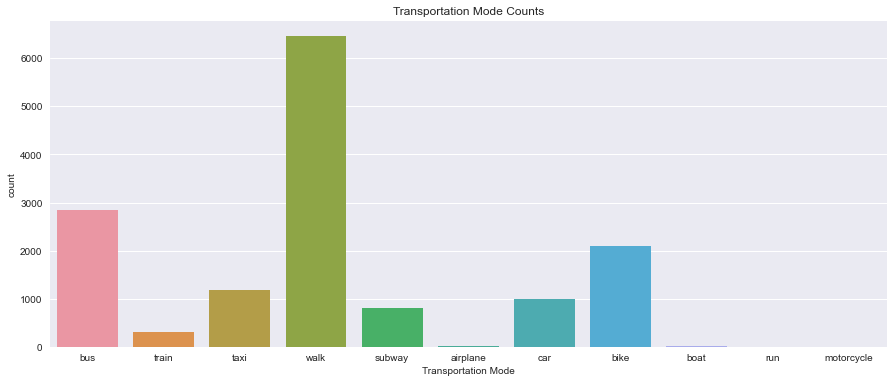

In [17]:
plt.style.use("seaborn")
plt.figure(figsize=(15,6))
sns.countplot(data=concatenated_label, x=concatenated_label["Transportation Mode"])
plt.title("Transportation Mode Counts")
plt.show()

### Travel Behaviours

#### The relationship between transportation mode and the time spent using that transportation mode

In [18]:
transport_time = concatenated_label
transport_time['start_datetime'] = pd.to_datetime(transport_time['Starting Date'] + ' ' + transport_time['Start Time'])
transport_time['end_datetime'] = pd.to_datetime(transport_time['End Date'] + ' ' + transport_time['End Time'])
transport_time['time_diff_hours'] = (transport_time['end_datetime'] - transport_time['start_datetime']) / pd.Timedelta(hours=1)

transport_time

,Start Time,End Time,Transportation Mode,Starting Date,End Date,user_name,start_datetime,end_datetime,time_diff_hours
0,11:32:29,11:40:29,bus,2007/06/26,2007/06/26,010,2007-06-26 11:32:29,2007-06-26 11:40:29,0.133333
1,14:52:54,15:59:59,train,2008/03/28,2008/03/28,010,2008-03-28 14:52:54,2008-03-28 15:59:59,1.118056
2,16:00:00,22:02:00,train,2008/03/28,2008/03/28,010,2008-03-28 16:00:00,2008-03-28 22:02:00,6.033333
3,01:27:50,15:59:59,train,2008/03/29,2008/03/29,010,2008-03-29 01:27:50,2008-03-29 15:59:59,14.535833
4,16:00:00,15:59:59,train,2008/03/29,2008/03/30,010,2008-03-29 16:00:00,2008-03-30 15:59:59,23.999722
...,...,...,...,...,...,...,...,...,...
14713,06:59:58,07:06:16,bus,2008/11/17,2008/11/17,179,2008-11-17 06:59:58,2008-11-17 07:06:16,0.105000
14714,07:06:16,07:14:32,walk,2008/11/17,2008/11/17,179,2008-11-17 07:06:16,2008-11-17 07:14:32,0.137778
14715,01:58:05,02:01:39,bus,2008/11/29,2008/11/29,179,2008-11-29 01:58:05,2008-11-29 02:01:39,0.059444
14716,02:01:39,02:07:57,walk,2008/11/29,2008/11/29,179,2008-11-29 02:01:39,2008-11-29 02:07:57,0.105000


#### Finding the relationship between transportation mode and time spent for each user logged in

In [19]:
transport_corr = transport_time.loc[:, ["Transportation Mode", "time_diff_hours"]]
transport_pivot = pd.pivot_table(data=transport_corr, values="time_diff_hours", columns="Transportation Mode", aggfunc=np.mean)
transport_pivot

Transportation Mode,airplane,bike,boat,bus,car,motorcycle,run,subway,taxi,train,walk
time_diff_hours,2.399837,1.153791,0.66381,0.528233,1.737297,0.093611,0.626343,0.487491,0.559027,2.493111,0.845279


In [20]:
transport_corr_user = transport_time.loc[:, ["Transportation Mode", "time_diff_hours", "user_name"]]
transport_user = transport_corr_user.groupby([transport_corr_user["user_name"], transport_corr_user["Transportation Mode"]])
for group, _ in transport_user.groups.items():
    print("Displaying Group: ", group[0])
    print(group)
    print(transport_user.get_group(group)["time_diff_hours"].mean())

Displaying Group:  010
('010', 'airplane')
2.1193055555555556
Displaying Group:  010
('010', 'bus')
0.4016269841269842
Displaying Group:  010
('010', 'car')
0.7877777777777778
Displaying Group:  010
('010', 'subway')
0.18974586288416073
Displaying Group:  010
('010', 'taxi')
0.24615162037037033
Displaying Group:  010
('010', 'train')
2.8166999999999995
Displaying Group:  010
('010', 'walk')
0.09842592592592592
Displaying Group:  020
('020', 'bike')
0.3702396514161221
Displaying Group:  020
('020', 'bus')
0.29531432748538017
Displaying Group:  020
('020', 'car')
1.0734722222222222
Displaying Group:  020
('020', 'subway')
5.51638888888889
Displaying Group:  020
('020', 'taxi')
0.06527777777777778
Displaying Group:  020
('020', 'train')
0.6848611111111111
Displaying Group:  020
('020', 'walk')
0.7391447368421054
Displaying Group:  021
('021', 'car')
2.147694444444445
Displaying Group:  021
('021', 'taxi')
0.3225
Displaying Group:  021
('021', 'walk')
2.2362301587301587
Displaying Group:  

### Common Routes Analysis

Copying the dataframe of concetenated_plt to routes for routes analysis

In [21]:
routes = beijing_df.copy()
routes

,Latitude,Longitude,Altitude (ft),Date,Time,user_name,Hour
0,39.921712,116.472343,13.0,2007-08-04,1900-01-01 03:30:32,010,3
1,39.921705,116.472343,13.0,2007-08-04,1900-01-01 03:30:33,010,3
2,39.921695,116.472345,13.0,2007-08-04,1900-01-01 03:30:34,010,3
3,39.921683,116.472342,13.0,2007-08-04,1900-01-01 03:30:35,010,3
4,39.921672,116.472342,13.0,2007-08-04,1900-01-01 03:30:36,010,3
...,...,...,...,...,...,...,...
12517359,40.007802,116.319362,84.0,2008-11-29,1900-01-01 08:15:52,179,8
12517360,40.007780,116.319360,88.0,2008-11-29,1900-01-01 08:15:54,179,8
12517361,40.007756,116.319362,92.0,2008-11-29,1900-01-01 08:15:56,179,8
12517362,40.007740,116.319361,97.0,2008-11-29,1900-01-01 08:15:58,179,8


In [22]:
routes["Longitude_diff"] = routes["Longitude"].diff().abs()
routes["Latitude_diff"] = routes["Latitude"].diff().abs()
routes = routes[(routes["Longitude_diff"]>0.01)&(routes["Latitude_diff"]>0.01)]
routes

,Latitude,Longitude,Altitude (ft),Date,Time,user_name,Hour,Longitude_diff,Latitude_diff
10842,39.990712,116.309635,128.0,2007-09-01,1900-01-01 02:23:40,010,2,0.010210,0.240372
11404,39.921747,116.471552,94.0,2007-09-03,1900-01-01 09:52:08,010,9,0.157474,0.026265
15446,39.900990,116.425737,167.0,2007-09-06,1900-01-01 20:45:21,010,20,0.125992,0.150952
21297,39.921752,116.470715,77.0,2007-09-08,1900-01-01 08:17:10,010,8,0.049105,0.020922
59326,40.082530,116.586048,115.0,2007-10-17,1900-01-01 22:02:38,010,22,0.022476,0.183217
...,...,...,...,...,...,...,...,...,...
12501849,40.019152,116.318527,-72.0,2008-11-07,1900-01-01 13:44:10,179,13,0.012512,0.013986
12502606,40.069851,116.314232,492.0,2008-11-09,1900-01-01 02:20:42,179,2,0.016060,0.017679
12502802,39.988636,116.330106,492.0,2008-11-09,1900-01-01 12:03:29,179,12,0.029450,0.061534
12503045,40.069906,116.313155,237.0,2008-11-09,1900-01-01 12:25:59,179,12,0.014298,0.053716


### Mapping of GPS Points

### Data Overview in Beijing

In [41]:
def get_color(hour):
    # Convert hour to color intensity (0-255)
    intensity = int(hour * 255 / 23)
    # Set red component to 210-255 range for orange hue
    red = max(min(intensity, 255), 250)
    # Set green and blue components to 0
    green = max(min(intensity - 55, 200), 100)
    blue = 0
    # Convert to hex format and return
    return "#{:02x}{:02x}{:02x}".format(red, green, blue)


# Create map
b = folium.Map(location=[39.9, 116.4], zoom_start=12, tiles='CartoDB dark_matter')

# Add lines to map
for user in routes['user_name'].unique():
    user_trips = routes[routes['user_name'] == user]
    user_points = list(zip(user_trips['Latitude'], user_trips['Longitude']))
    user_hours = user_trips['Hour']
    color = get_color(user_hours.mean())
    folium.PolyLine(user_points, color=color, weight=0.2).add_to(b)

title_html = '<h3 align="center" style="font-size:20px"><b>Data Overview in Beijing</b></h3>'
b.get_root().html.add_child(folium.Element(title_html))
folium.LayerControl().add_to(b)
b

### Hexbin view of Beijing

In [42]:
url = "https://kepler.gl/demo/map?mapUrl=https://dl.dropboxusercontent.com/s/w2z1t92fvwkred9/keplergl_b75e29n.json"
IFrame(url, width=950, height=600)

# Machine Learning

#### Research Question: What factors influence the urban development of an area?

#### Feature Engineering 

In [ ]:
Beijing_zone = beijing_df
# Define the number of zones you want to create
num_zones = 1000

# Use k-means clustering to transform the latitudes and longitudes into zones
kmeans = KMeans(n_clusters=num_zones, random_state=0).fit(Beijing_zone[['Latitude', 'Longitude']])
Beijing_zone['zone'] = kmeans.labels_+1

# Group the data by zone and calculate the number of users, average hour, and area for each zone
grouped = Beijing_zone.groupby('zone').agg(num_users=('user_name', 'nunique'),
                                  avg_hour=('Hour', 'mean'),
                                  lat_mean=('Latitude', 'mean'),
                                  lon_mean=('Longitude', 'mean'))

grouped['radius_km'] = grouped.apply(lambda row: max(haversine((row['lat_mean'], row['lon_mean']), 
                                                               (lat, lon), unit=Unit.KILOMETERS) 
                                                      for lat, lon in zip(Beijing_zone[Beijing_zone['zone'] == row.name]['Latitude'], 
                                                                          Beijing_zone[Beijing_zone['zone'] == row.name]['Longitude'])), axis=1)

grouped['area_km2'] = grouped['radius_km'] ** 2 * 3.14159

# Create a new dataframe with the zone, number of users, average hour, and area for each zone
Beijing_new = pd.DataFrame({'zone': grouped.index,
                       'num_users': grouped['num_users'].values,
                       'avg_hour': grouped['avg_hour'].values,
                       'area_km2': grouped['area_km2'].values})
Beijing_new

C:\Users\Omer Tafveez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
Beijing_new["Transportation Mode"] = concatenated_label["Transportation Mode"].value_counts()[:10].index
Beijing_new

In [ ]:
Beijing_new = pd.get_dummies(Beijing_new, columns=["Transportation Mode"])
Beijing_new